In [ ]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# define the standalone discriminator model
def def_discriminator(in_shape=(28,28,1)):
	dmodel = Sequential()
	dmodel.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	dmodel.add(LeakyReLU(alpha=0.2))
	dmodel.add(Dropout(0.4))
	dmodel.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	dmodel.add(LeakyReLU(alpha=0.2))
	dmodel.add(Dropout(0.4))
	dmodel.add(Flatten())
	dmodel.add(Dense(1, activation='sigmoid'))
	optim = Adam(lr=0.0005, beta_1=0.8)
	dmodel.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
	return dmodel

In [ ]:
# define the standalone generator model
def def_generator(latent_dim):
	gmodel = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gmodel.add(Dense(n_nodes, input_dim=latent_dim))
	gmodel.add(LeakyReLU(alpha=0.2))
	gmodel.add(Reshape((7, 7, 128)))
	# upsample to 14x14
  gmodel.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	gmodel.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	gmodel.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	gmodel.add(LeakyReLU(alpha=0.2))
	gmodel.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return gmodel

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def def_gan(gen_model, disc_model):
	# make weights in the discriminator not trainable
	disc_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(gen_model)
	# add the discriminator
	model.add(disc_model)
	# compile model
	optim = Adam(lr=0.0005, beta_1=0.8)
	model.compile(loss='binary_crossentropy', optimizer=optim)
	return model

In [ ]:
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(x_input)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	for i in range(n * n):
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	X_real, y_real = generate_real_samples(dataset, n_samples)
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	save_plot(x_fake, epoch)
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			d_loss, _ = d_model.train_on_batch(X, y)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		if (i+1) % 3 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
latent_dim = 100
d_model = def_discriminator()
g_model = def_generator(latent_dim)
gan_model = def_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>79, 156/234, d=0.690, g=0.698
>79, 157/234, d=0.692, g=0.713
>79, 158/234, d=0.694, g=0.700
>79, 159/234, d=0.696, g=0.718
>79, 160/234, d=0.696, g=0.719
>79, 161/234, d=0.694, g=0.703
>79, 162/234, d=0.683, g=0.712
>79, 163/234, d=0.693, g=0.698
>79, 164/234, d=0.687, g=0.687
>79, 165/234, d=0.690, g=0.700
>79, 166/234, d=0.693, g=0.708
>79, 167/234, d=0.692, g=0.718
>79, 168/234, d=0.689, g=0.712
>79, 169/234, d=0.687, g=0.710
>79, 170/234, d=0.691, g=0.704
>79, 171/234, d=0.684, g=0.680
>79, 172/234, d=0.705, g=0.687
>79, 173/234, d=0.690, g=0.692
>79, 174/234, d=0.698, g=0.719
>79, 175/234, d=0.699, g=0.708
>79, 176/234, d=0.693, g=0.698
>79, 177/234, d=0.694, g=0.682
>79, 178/234, d=0.685, g=0.698
>79, 179/234, d=0.698, g=0.725
>79, 180/234, d=0.694, g=0.718
>79, 181/234, d=0.685, g=0.697
>79, 182/234, d=0.695, g=0.698
>79, 183/234, d=0.688, g=0.699
>79, 184/234, d=0.689, g=0.710
>79, 185/234, d=0.694, g=0.699
>79, 186/234, d=0.6

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]


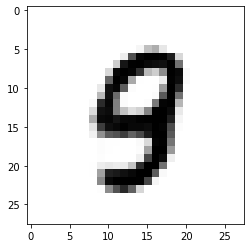

In [ ]:
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot

model = load_model('generator_model_099.h5')
vector = asarray([[0.0 for _ in range(100)]])
print (vector)
X = model.predict(vector)
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()

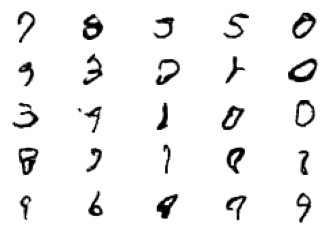

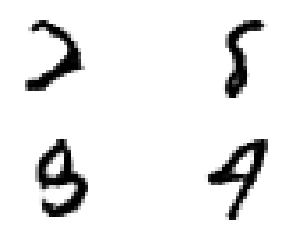

In [ ]:

# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('generator_model_099.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model
model = load_model('generator_model_099.h5')
# generate images
latent_points = generate_latent_points(100, 4)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 2)